Created on Thu Oct 26 10:28:08 2023

@author: Santiago D'hers

Use:

- This script will create the geolabels and calculate the distance traveled

Requirements:

- The position.csv files processed by 1-Manage_H5.py

In [5]:
import os
from glob import glob
import pandas as pd
import numpy as np

import plotly.graph_objects as go

import random

In [6]:
class Point:
    def __init__(self, df, table):

        x = df[table + '_x']
        y = df[table + '_y']

        self.positions = np.dstack((x, y))[0]

    @staticmethod
    def dist(p1, p2):
        return np.linalg.norm(p1.positions - p2.positions, axis=1)

class Vector:
    def __init__(self, p1, p2, normalize=True):

        self.positions = p2.positions - p1.positions

        self.norm = np.linalg.norm(self.positions, axis=1)

        if normalize:
            self.positions = self.positions / np.repeat(np.expand_dims(self.norm,axis=1), 2, axis=1)

    @staticmethod
    def angle(v1, v2):
        
        length = len(v1.positions)
        angle = np.zeros(length)

        for i in range(length):
            angle[i] = np.rad2deg(np.arccos(np.dot(v1.positions[i], v2.positions[i])))

        return angle

In [11]:
# State your path:
path = r'C:\Users\dhers\OneDrive - UBA\workshop'
experiment = r'TORM'

all_position = glob(os.path.join(path, experiment,"*/position/*position.csv"))

# Set the parameters to consider exploration
objects = ['obj_1', 'obj_2'] # Name the stationary objects that may appear on your data
distance = 2.5
angle = 45

In [25]:
TS_files = [file for file in all_position if 'TS' in file] 

if not TS_files:
    print("No TS_files found")
    example = random.choice(all_position)
    print(f"Plotting coordinates from {os.path.basename(example)}")

else:
    # Choose one file at random to use as example
    example = random.choice(TS_files)
    print(f"Plotting coordinates from {os.path.basename(example)}")

Plotting coordinates from 2023-05_TORM-2m-24h_TS_C1_A_L_position.csv


In [ ]:
h5_files = [file for file in os.listdir(folder) if file.endswith('position.h5') and 'TS' in file] 

if not h5_files:
    print("No files found")

else:
    # Choose one file at random to use as example
    example = random.choice(h5_files)
    example_path = os.path.join(folder, example)
    print(f"Plotting coordinates from {example}")

Plotting coordinates from 2023-05_TORM-2m-24h_TS_C3_B_R_position.h5


In [20]:
# Function to plot mouse exploration around multiple objects
def plot_position(file, obj_list, maxDistance=distance, maxAngle=angle):

    color_list = ['blue', 'red', 'green', 'orange', 'purple', 'yellow', 'black', 'grey']
    symbol_list = ['square', 'circle', 'diamond', 'cross', 'x', 'triangle-up', 'triangle-down', 'star']
    
    # Read the .csv
    df = pd.read_csv(file)

    # Extract body parts
    nose = Point(df, 'nose')
    head = Point(df, 'head')

    # Create the main trace for nose positions
    nose_trace = go.Scatter(
        x=nose.positions[:, 0],
        y=nose.positions[:, 1],
        mode='markers',
        marker=dict(color='grey', opacity=0.2),
        name='Nose Positions'
    )
    
    # Store all traces
    traces = [nose_trace]

    # Loop over each object in the list of object names
    for idx, obj in enumerate(obj_list):
        # Extract the object coordinates from the DataFrame using the object name
        obj_x_col = f'{obj}_x'
        obj_y_col = f'{obj}_y'

        # Create a Point object for the object
        obj_coords = Point(df, obj)

        # Find distance from the nose to the object
        dist = Point.dist(nose, obj_coords)
        
        # Compute the normalized head-object vector
        head_nose = Vector(head, nose, normalize=True)
        head_obj = Vector(head, obj_coords, normalize=True)
        
        # Find the angle between the head-nose and head-object vectors
        angle = Vector.angle(head_nose, head_obj)  # in degrees
        
        # Filter nose positions oriented towards the object
        towards_obj = nose.positions[(angle < maxAngle) & (dist < maxDistance**2)]
        
        # Create trace for filtered points oriented towards the object
        towards_trace = go.Scatter(
            x=towards_obj[:, 0],
            y=towards_obj[:, 1],
            mode='markers',
            marker=dict(opacity=0.4),
            name=f'Towards {obj}'
        )

        # Assign colors and symbols dynamically based on index
        object_color = color_list[idx]
        object_symbol = symbol_list[idx]

        # Create trace for the object
        obj_trace = go.Scatter(
            x=[obj_coords.positions[0][0]],
            y=[obj_coords.positions[0][1]],
            mode='markers',
            marker=dict(symbol=object_symbol, size=18, color=object_color),
            name=f'{obj}'
        )

        # Create circle around the object
        circle_trace = go.Scatter(
            x=obj_coords.positions[0][0] + maxDistance * np.cos(np.linspace(0, 2 * np.pi, 100)),
            y=obj_coords.positions[0][1] + maxDistance * np.sin(np.linspace(0, 2 * np.pi, 100)),
            mode='lines',
            line=dict(color='green', dash='dash'),
            name=f'{obj} Radius'
        )

        # Append object-specific traces
        traces.append(towards_trace)
        traces.append(obj_trace)
        traces.append(circle_trace)

    # Extract the filename without extension
    filename = os.path.splitext(os.path.basename(file))[0]

    # Create layout
    layout = go.Layout(title=f'Analysis of {filename}',
                       xaxis=dict(title='Horizontal position (cm)', scaleanchor='y'),  # Lock aspect ratio to the y-axis
                       yaxis=dict(title='Vertical position (cm)'),
                       showlegend=True,
                       width=768,
                       height=512,
                       )

    # Create figure
    fig = go.Figure(data=traces, layout=layout)

    # Show plot
    fig.show()

In [21]:
plot_position(example, obj_list = objects)

   freezing
0         0
1         0
2         0
3         0
4         0


<Axes: >

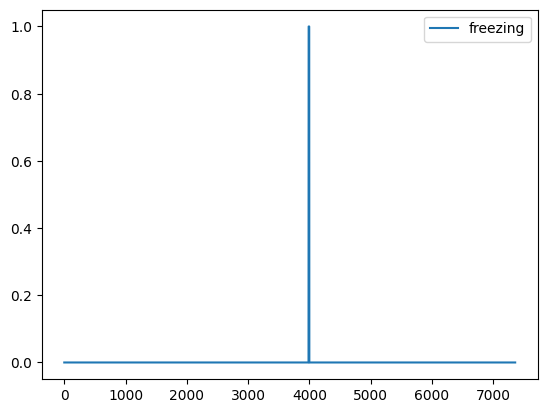

In [22]:
# Load the CSV file
df = pd.read_csv(example)

movement = df.diff().rolling(window=25, center=True).std().mean(axis=1)

freezing_df = pd.DataFrame(np.where(movement < 0.005, 1, 0), columns=['freezing'])

print(freezing_df.head())

freezing_df.plot()

In [23]:
def create_geolabels(files, objects, maxDistance = 2.5, maxAngle = 45):
    
    for file in files:
        
        # Determine the output file path
        input_dir, input_filename = os.path.split(file)
        parent_dir = os.path.dirname(input_dir)
        
        # Read the file
        position = pd.read_csv(file)

        # Extract body parts
        nose = Point(position, 'nose')
        head = Point(position, 'head')

        # Check if all required object columns exist
        missing_objects = []
        for obj in objects:
            if f'{obj}_x' not in position.columns or f'{obj}_y' not in position.columns:
                missing_objects.append(obj)

        if not missing_objects: # this should be optimized to process files if they have some missing objects but not all.

            # Initialize geolabels dataframe with columns for each object
            geolabels = pd.DataFrame(np.zeros((position.shape[0], len(objects))), columns=objects) 

            # Loop through each object in the list
            for obj in objects:

                # Extract the object's coordinates from the DataFrame
                obj_coords = Point(position, obj)
                
                # Calculate the distance and angle between nose and the object
                dist = Point.dist(nose, obj_coords)
                head_nose = Vector(head, nose, normalize=True)
                head_obj = Vector(head, obj_coords, normalize=True)
                angle = Vector.angle(head_nose, head_obj)

                # Loop over each frame and assign the geolabel if the mouse is exploring the object
                for i in range(position.shape[0]):
                    if dist[i] < maxDistance and angle[i] < maxAngle:
                        geolabels.loc[i, obj] = 1  # Assign 1 if exploring the object

            # Convert geolabels to integer type (0 or 1)
            geolabels = geolabels.astype(int)

            # Insert a new column with the frame number at the beginning of the DataFrame
            geolabels.insert(0, "Frame", geolabels.index + 1)

            # Create a filename for the output CSV file
            output_filename_geolabels = input_filename.replace('_position.csv', '_geolabels.csv')
            output_folder_geolabels = os.path.join(parent_dir + '/geolabels')
            os.makedirs(output_folder_geolabels, exist_ok=True)
            output_path_geolabels = os.path.join(output_folder_geolabels, output_filename_geolabels)

            # Save geolabels to CSV
            geolabels.to_csv(output_path_geolabels, index=False)
            print(f"Saved geolabels to {output_filename_geolabels}")
        
        else:
            print(f"{input_filename} is missing objects: {', '.join(missing_objects)}")

        # Create the distances dataframe
        distances = pd.DataFrame(np.zeros((position.shape[0], 2)), columns=["nose_dist", "body_dist"])
        
        # Calculate the Euclidean distance between consecutive nose positions
        distances['nose_dist'] = (((position['nose_x'].diff())**2 + (position['nose_y'].diff())**2)**0.5) / 100
        distances['body_dist'] = (((position['body_x'].diff())**2 + (position['body_y'].diff())**2)**0.5) / 100
        
        # Insert a new column with the frame number at the beginning of the DataFrame
        distances.insert(0, "Frame", distances.index + 1)
        
        output_filename_distances = input_filename.replace('_position.csv', '_distances.csv')
        output_folder_distances = os.path.join(parent_dir + '/distances')
        os.makedirs(output_folder_distances, exist_ok = True)
        output_path_distances = os.path.join(output_folder_distances, output_filename_distances)
        distances.to_csv(output_path_distances, index=False)
            
        print(f"Saved distances to {output_filename_distances}")

In [24]:
create_geolabels(all_position, objects)

Saved geolabels to 2023-05_TORM-2m-24h_TS_C1_A_L_geolabels.csv
Saved distances to 2023-05_TORM-2m-24h_TS_C1_A_L_distances.csv
Saved geolabels to 2023-05_TORM-2m-24h_TS_C1_A_R_geolabels.csv
Saved distances to 2023-05_TORM-2m-24h_TS_C1_A_R_distances.csv
Saved geolabels to 2023-05_TORM-2m-24h_TS_C1_B_L_geolabels.csv
Saved distances to 2023-05_TORM-2m-24h_TS_C1_B_L_distances.csv
Saved geolabels to 2023-05_TORM-2m-24h_TS_C1_B_R_geolabels.csv
Saved distances to 2023-05_TORM-2m-24h_TS_C1_B_R_distances.csv
Saved geolabels to 2023-05_TORM-2m-24h_TS_C2_A_L_geolabels.csv
Saved distances to 2023-05_TORM-2m-24h_TS_C2_A_L_distances.csv
Saved geolabels to 2023-05_TORM-2m-24h_TS_C2_A_R_geolabels.csv
Saved distances to 2023-05_TORM-2m-24h_TS_C2_A_R_distances.csv
Saved geolabels to 2023-05_TORM-2m-24h_TS_C2_B_L_geolabels.csv
Saved distances to 2023-05_TORM-2m-24h_TS_C2_B_L_distances.csv
Saved geolabels to 2023-05_TORM-2m-24h_TS_C2_B_R_geolabels.csv
Saved distances to 2023-05_TORM-2m-24h_TS_C2_B_R_distan